- From BACCH paper: In this form, $z$ is defined as $z = e^{i2\omega\tau_c}$, where $\tau_c$ is a time delay expressed in microseconds (µs), 
- This represents a complex exponential corresponding to a $\tau_c$ delay in frequency domain. 
- This is a symbolic algebraic representation used for analytical manipulation in the paper.

$$
\begin{align}
H_\rm{ipsi} 
&= \frac{z^2g^2-z(\beta+1)}{z^2g^2+g^2-z[(g^2+\beta)^2+2\beta+1]} \\
&= \frac{g^2-(\beta+1)z^{-1}}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-1}+g^2z^{-2}}\\
\end{align}
$$

$$
\begin{align}
H_\rm{cont} 
&= \frac{z[gz^{-0.5}-g(g^2+\beta)z^{0.5}]}{z^2g^2+g^2-z[(g^2+\beta)^2+2\beta+1]} \\
&= \frac{z^{-1}[gz^{-0.5}-g(g^2+\beta)z^{0.5}]}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-1}+g^2z^{-2}}\\
&= \frac{[gz^{-1.5}-g(g^2+\beta)z^{-0.5}]}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-1}+g^2z^{-2}}\\
&= \frac{-g(g^2+\beta)z^{-0.5}+gz^{-1.5}}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-1}+g^2z^{-2}}\\
\end{align}
$$

- Now: reformulated using $\tau$ as number of delay samples, and expressing each term using $z^{-n}$, for actual DSP implementation.
- Here, $z^{-1}$ corresponds to one sample delay, so $z^{-2\tau}$ = delay by $2\tau$ samples (because BACCH uses a $2\tau_c$ delay as base unit)

$$
\begin{align}
H_\rm{ipsi} 
&= \frac{g^2-(\beta+1)z^{-2\tau}}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-2\tau}+g^2z^{-4\tau}}\\
\end{align}
$$

$$
\begin{align}
H_\rm{cont} 
&= \frac{-g(g^2+\beta)z^{-\tau}+gz^{-3\tau}}{g^2-[(g^2+\beta)^2+2\beta+1]z^{-2\tau}+g^2z^{-4\tau}}\\
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def generate_filter_coeffs(g, beta, tau):
    N = 4 * tau + 1  # total length required
    
    # --- Ipsi numerator ---
    b_ipsi = np.zeros(N)
    b_ipsi[0] = g**2
    b_ipsi[2 * tau] = -(beta + 1)

    # --- Cont numerator ---
    b_cont = np.zeros(N)
    b_cont[tau] = -g * (g**2 + beta)
    b_cont[3 * tau] = g

    # --- Shared denominator ---
    a = np.zeros(N)
    a[0] = g**2
    a[2 * tau] = -((g**2 + beta)**2 + 2 * beta + 1)
    a[4 * tau] = g**2

    return b_ipsi, b_cont, a

def analysis_cancellation(b_ipsi, b_cont, a, g, tau):
    """
    Compute and plot the crosstalk cancellation spectrum
    using IIR filter coefficients.

    Parameters:
    - b_ipsi: numerator coefficients of ipsilateral filter
    - b_cont: numerator coefficients of contralateral filter
    - a: denominator coefficients (shared by both filters)
    - g: gain parameter
    - tau: delay in samples
    """
    # Compute frequency response of each filter
    w, H_ipsi = signal.freqz(b_ipsi, a)
    w, H_cont = signal.freqz(b_cont, a)

    # Apply g and delay logic directly (in frequency domain)
    # delay = e^{-iωτ}, so we use exp(-1j * w * tau)
    delay = np.exp(-1j * w * tau)
    Compensate = H_ipsi + g * H_cont * delay
    Cancel = H_cont + g * H_ipsi * delay

    # Compute cancellation metric
    cancellation = np.abs(Compensate) / np.abs(Cancel)

    # Plot
    plt.title('Crosstalk Cancellation Spectrum')
    plt.plot(w, 20 * np.log10(cancellation), label="XTC Cancellation")
    plt.legend()
    plt.grid()
    plt.ylim(-48, 60)
    plt.xlabel("Radian Frequency (Ω)")
    plt.ylabel("Amplitude (dB)")
    plt.show()
    
def analysis_coloration(b_ipsi, b_cont, a, sample_rate):
    """
    Analyze coloration introduced by crosstalk cancellation filters
    using IIR filter coefficients.

    Parameters:
    - b_ipsi: numerator coefficients of ipsilateral filter
    - b_cont: numerator coefficients of contralateral filter
    - a: denominator coefficients (shared by both filters)
    - sample_rate: sampling rate in Hz
    """
    w, h_ipsi = signal.freqz(b_ipsi, a, fs=sample_rate)
    w, h_cont = signal.freqz(b_cont, a, fs=sample_rate)

    si = np.abs(h_ipsi + h_cont)
    so = np.abs(h_ipsi - h_cont)

    plt.title('Crosstalk Cancellation Filter Coloration Spectrum')
    plt.plot(w, 20 * np.log10(np.maximum(si, so)), label='Max(|L+R|, |L−R|)')
    plt.ylim(-30, 12)
    plt.legend()
    plt.grid()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.show()

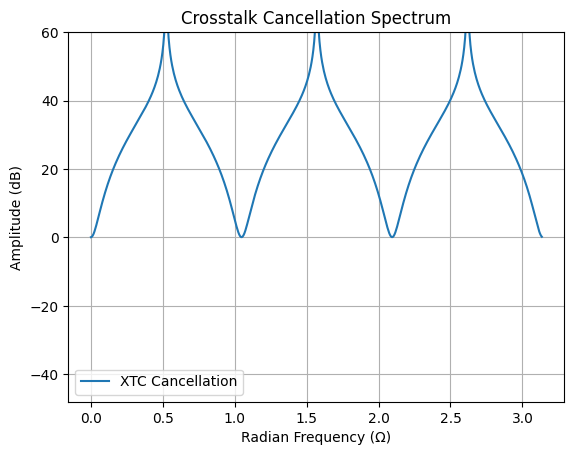

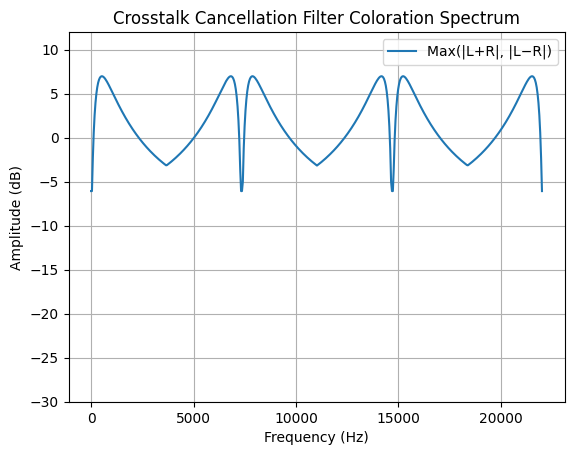

In [3]:
g = 0.985
beta = 0.05
tau = 3  # e.g., 3 samples ≈ 68us @ 44.1kHz
sample_rate = 44100

b_ipsi, b_cont, a = generate_filter_coeffs(g, beta, tau)
analysis_cancellation(b_ipsi, b_cont, a, g, tau)
analysis_coloration(b_ipsi, b_cont, a, sample_rate)

$$
\begin{align}
H_{\rm{ipsi}} 
&= \frac{z^2g^2\bar{h^2}-z(\beta+1)}{g^2\bar{h}^2-((g^2h\bar{h}+\beta)^2+2\beta+1)z^{-1}+g^2h^2z^{-2}}\\
H_{\rm{cont}} 
&= \frac{z^{-1}[ghz^{-0.5}-(g^2h\bar{h}+\beta)g\bar{h}z^{0.5}]}{g^2\bar{h}^2-((g^2h\bar{h}+\beta)^2+2\beta+1)z^{-1}+g^2h^2z^{-2}}\\
\end{align}
$$

$$
\begin{align}
H_{\rm{ipsi-hs}} 
&= \frac{g^2\bar{h^2}-(\beta+1)z^{-2\tau}}{g^2\bar{h}^2-((g^2h\bar{h}+\beta)^2+2\beta+1)z^{-2\tau}+g^2h^2z^{-4\tau}}\\
H_{\rm{cont-hs}} 
&= \frac{-(g^2h\bar{h}+\beta)g\bar{h}z^{-\tau}+ghz^{-3\tau}}{g^2\bar{h}^2-((g^2h\bar{h}+\beta)^2+2\beta+1)z^{-2\tau}+g^2h^2z^{-4\tau}}\\
\end{align}
$$

In [4]:
from sympy import symbols, cos, sqrt, Matrix, print_latex, simplify, fraction, latex, expand, collect, Poly
from IPython.display import display, Markdown

z, a0, a1, b0, b1, g, tau, beta, D, N, d, n = symbols('z a_0 a_1 b_0 b_1 g t B D N d n')

h = (N/D)
hr = (n/d)

h_x_h = (h*h)
h_x_hr = (h*hr)
hr_x_hr = (hr*hr)

display(Markdown(rf"$$A^{2}={latex(h_x_h)}$$"))
display(Markdown(rf"$$AB={latex(h_x_hr)}$$"))
display(Markdown(rf"$$BB={latex(hr_x_hr)}$$"))

numerator_ipsi = (g**2 * hr_x_hr - (beta + 1)*z**(-2*tau))*D*D*d*d
numerator_ipsi = simplify(numerator_ipsi)

numerator_cont = (-(g**2*h_x_hr+beta)*g*hr*z**(-1*tau)+g*h*z**(-3*tau)) *D*D*d*d
numerator_cont = simplify(numerator_cont)

denominator = (g**2 * hr_x_hr - (((g**2 * h_x_hr + beta)**2 + 2*beta + 1)*z**(-2*tau)) + (g**2 * h_x_h * z**(-4*tau)))*D*D*d*d
denominator = simplify(denominator)

display(Markdown(rf"$$Num1={latex(numerator_ipsi)}$$"))
display(Markdown(rf"$$Num2={latex(numerator_cont)}$$"))
display(Markdown(rf"$$Den={latex(denominator)}$$"))

$$A^2=\frac{N^{2}}{D^{2}}$$

$$AB=\frac{N n}{D d}$$

$$BB=\frac{n^{2}}{d^{2}}$$

$$Num1=D^{2} z^{- 2 t} \left(- d^{2} \left(B + 1\right) + g^{2} n^{2} z^{2 t}\right)$$

$$Num2=D g z^{- 3 t} \left(N d^{2} - n z^{2 t} \left(B D d + N g^{2} n\right)\right)$$

$$Den=z^{- 4 t} \left(D^{2} g^{2} n^{2} z^{4 t} + N^{2} d^{2} g^{2} - z^{2 t} \left(D^{2} d^{2} \left(2 B + 1\right) + \left(B D d + N g^{2} n\right)^{2}\right)\right)$$

$$
\begin{align}
{\rm{Num}_{ipsi}} &= g^2(DDdd) - (\beta+1)(DDdd)z^{-2\tau}\\
{\rm{Num}_{cont}} &= -g^3(DNnn)z^{-\tau}-\beta(DDdn)z^{-\tau} + g(DddN)z^{-3\tau} \\
{\rm{Den}_{shared}} &= g^2(DDdd) - g^4(NNnn)z^{-2\tau} + 2 \beta g (DdNn)z^{-2\tau} + (\beta+1)^2(DDdd)z^{-2\tau} + g^2(NNdd)z^{-4\tau}\\
\end{align}
$$

$$
\begin{align}
     h  &= \frac{b_0 + b_1z^{-1}}{a_0 + a_1z^{-1}}\\
\bar{h} &= \frac{b_1 + b_0z^{-1}}{a_1 + a_0z^{-1}}\\
\end{align}
$$

$$
\begin{align}
hh 
&= \frac{b_0^2 + 2b_0b_1z^{-1}+b_1^2z^{-2}}{a_0^2 + 2a_0a_1z^{-1}+a_1^2z^{-2}}\\
\bar{h}\bar{h} 
&= \frac{b_1^2 + 2b_0b_1z^{-1}+b_0^2z^{-2}}{a_1^2 + 2a_0a_1z^{-1}+a_0^2z^{-2}}\\
\bar{h}h 
&= \frac{b_0b_1+(b_0^2+b_1^2)z^{-1}+b_0b_1z^{-2}}{a_0a_1+(b_0^2+b_1^2)z^{-1}+a_0a_1z^{-2}}\\
\bar{h}^2h^2 
&= \frac{
(b_0 b_1)^2 + 2b_0 b_1 (b_0^2 + b_1^2) z^{-1} + \left[(b_0^2 + b_1^2)^2 + 2(b_0 b_1)^2\right] z^{-2} + 2b_0 b_1 (b_0^2 + b_1^2) z^{-3} + (b_0 b_1)^2 z^{-4}
}{
(a_0 a_1)^2 + 2a_0 a_1 (b_0^2 + b_1^2) z^{-1} + \left[(b_0^2 + b_1^2)^2 + 2(a_0 a_1)^2\right] z^{-2} + 2a_0 a_1 (b_0^2 + b_1^2) z^{-3} + (a_0 a_1)^2 z^{-4}
}
\end{align}
$$

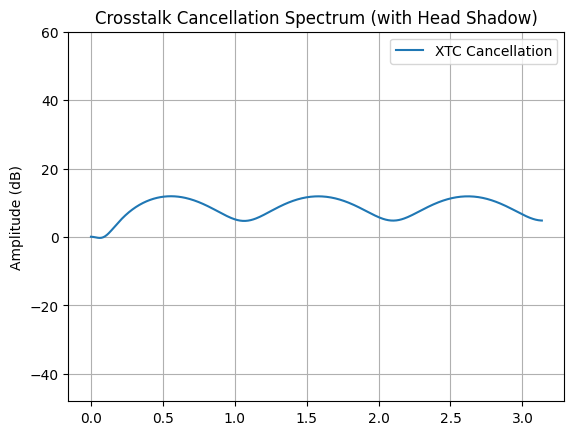

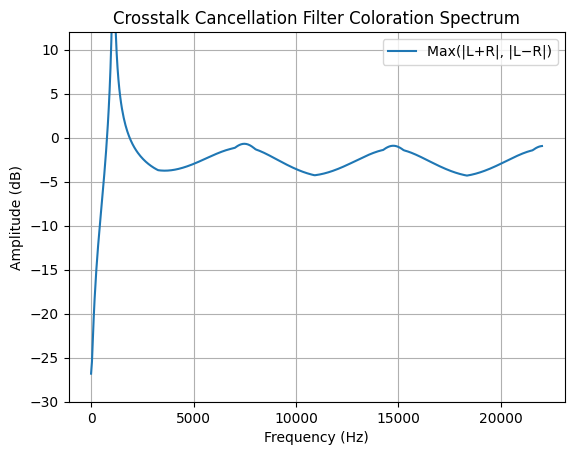

In [47]:
def convolve_all(*args):
    result = np.array([1.0])
    for a in args:
        result = np.convolve(result, a)
    return result
    
def generate_filter_coeffs(g, beta, tau, N, D):
    offset = 5 # order of cascade 1st order filter for 4 times!
    size = 4 * tau + offset  # total length required

    # conjugate
    n = N[::-1]
    d = D[::-1]

    b_ipsi = np.zeros(size)
    b_cont = np.zeros(size)
    a = np.zeros(size)
    
    # --- Ipsi numerator ---
    b_ipsi[0:offset] += g**2 * convolve_all(D,D,d,d) 
    b_ipsi[2*tau:2*tau+offset] += -(beta + 1) * convolve_all(D,D,d,d)

    # --- Cont numerator ---
    b_cont[tau:tau+offset] += -g**3 * convolve_all(D, N, n, n)
    b_cont[tau:tau+offset] += -beta * convolve_all(D, D, d, n)
    b_cont[3*tau:3*tau+offset] += g * convolve_all(D, d, d, N)

    # --- Shared denominator ---
    a[0:offset] += g**2 * convolve_all(D, D, d, d) 
    a[2*tau:2*tau+offset] += -g**4 * convolve_all(N, N, n, n)
    a[2*tau:2*tau+offset] += 2 * beta * g * convolve_all(D, d, N, n)
    a[2*tau:2*tau+offset] += (beta+1)**2 * convolve_all(D, D, d, d)
    a[4*tau:4*tau+offset] += g**2 * convolve_all(N, N, d, d)

    return b_ipsi, b_cont, a

def analysis_cancellation(b_ipsi, b_cont, a, Num, Den, g, tau):
    """
    Compute and plot the crosstalk cancellation spectrum
    using IIR filter coefficients and a head shadow model.

    Parameters:
    - b_ipsi: numerator coefficients of ipsilateral filter
    - b_cont: numerator coefficients of contralateral filter
    - a: shared denominator coefficients
    - b_h: numerator of head shadow filter
    - a_h: denominator of head shadow filter
    - g: gain parameter
    - tau: delay in samples
    - fs: sample rate (or 2π for radian freq)
    """
    # Frequency response of filter
    w, H_ipsi = signal.freqz(b_ipsi, a)
    _, H_cont = signal.freqz(b_cont, a)

    # Frequency response of head shadow filter
    _, H_hs = signal.freqz(Num, Den)

    # Total contralateral path: g * h(ω) * e^{-iωτ}
    acoustic_path = g * H_hs * np.exp(-1j * w * tau)

    # Reconstruct signals
    Compensate = H_ipsi + acoustic_path * H_cont
    Cancel     = H_cont + acoustic_path * H_ipsi

    # Compute cancellation metric
    cancellation = np.abs(Compensate) / np.abs(Cancel)

    # Plot
    plt.title('Crosstalk Cancellation Spectrum (with Head Shadow)')
    plt.plot(w, 20 * np.log10(cancellation), label="XTC Cancellation")
    plt.legend()
    plt.grid()
    plt.ylim(-48, 60)
    plt.ylabel("Amplitude (dB)")
    plt.show()

def analysis_coloration(b_ipsi, b_cont, a, sample_rate):
    """
    Analyze coloration introduced by crosstalk cancellation filters
    using IIR filter coefficients.

    Parameters:
    - b_ipsi: numerator coefficients of ipsilateral filter
    - b_cont: numerator coefficients of contralateral filter
    - a: denominator coefficients (shared by both filters)
    - sample_rate: sampling rate in Hz
    """
    w, h_ipsi = signal.freqz(b_ipsi, a, fs=sample_rate)
    w, h_cont = signal.freqz(b_cont, a, fs=sample_rate)

    si = np.abs(h_ipsi + h_cont)
    so = np.abs(h_ipsi - h_cont)

    plt.title('Crosstalk Cancellation Filter Coloration Spectrum')
    plt.plot(w, 20 * np.log10(np.maximum(si, so)), label='Max(|L+R|, |L−R|)')
    plt.ylim(-30, 12)
    plt.legend()
    plt.grid()
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude (dB)")
    plt.show()

g = 0.985
beta = 0.05
tau = 3  # e.g., 3 samples ≈ 68us @ 44.1kHz
sample_rate = 44100

# [1.7426871031535056, -1.5794217970310567] [1, -0.8367346938775511]
# [0.3491496315403721, -0.1858843254179231] [1, -0.8367346938775511]
N = [1.7426871031535056, -1.5794217970310567]
D = [1, -0.8367346938775511]

b_ipsi, b_cont, a = generate_filter_coeffs(g, beta, tau, N, D)
analysis_cancellation(b_ipsi, b_cont, a, N, D, g, tau)
analysis_coloration(b_ipsi, b_cont, a, sample_rate)